In [1]:
import pandas as pd
import numpy
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('ggplot')
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import joblib
from scipy.integrate import simps
from datetime import datetime
import sklearn.metrics as metrics
from xgboost import XGBClassifier

def norm_minimax(datos_train, datos_test=None, splits=True, mini=None, maxi=None):
    if (mini is None) and (maxi is None):
        maxi=(np.max(datos_train))
        mini=(np.min(datos_train))
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train, mini, maxi
    if (mini is not None) & (maxi is not None) & (splits==True):
        datos_train = (datos_train-mini)/(maxi-mini)
        datos_test = (datos_test-mini)/(maxi-mini)
        return datos_train, datos_test
    if (mini is not None) & (maxi is not None) & (splits==False):
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train
    print('Error de entradas en nomalizacion minimax')
    return -1

# calcular peso de clase para darselo al modelo
def pesos_clases(y_train, only_pos=False):
    cant_refa = 0
    cant_norefa = 0
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            cant_refa = cant_refa + 1
        else:
            cant_norefa = cant_norefa + 1
    total = cant_norefa + cant_refa
    porcentaje_refa = (cant_refa/total)*100
    print('Porcentaje de refacturas: %0.2f' % porcentaje_refa)
    weight_for_0 = (1 / cant_norefa)*(total)/2.0 
    weight_for_1 = ((1 / cant_refa)*(total)/2.0) #/2 #dividido 2 para que no haya tantos falsos positivos
    class_weight = {0: weight_for_0, 1: weight_for_1}
    #weight = cant_norefa/cant_refa
    print('Peso de clase "0" (sin refactura): {:.2f}'.format(weight_for_0))
    print('Peso de clase "1" (con refactura): {:.2f}'.format(weight_for_1))
    if only_pos==False:
        return weight_for_0, weight_for_1
    else:
        return weight_for_1

def curva_ROC(fpr, tpr, roc_auc):  
    # method I: plt
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--', color='RoyalBlue')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    #plt.savefig("ROC" + str(w) + '-' + T + ".jpg")
    plt.show()

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y, umbral=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Blues');
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    #plt.savefig("matriz_confusion" + str(w) + '-' + T + ".jpg")
    plt.show()
    #print (classification_report(y_test, pred_y))
    
def MOSTRAR_METRICAS(y_test, pred_y, umbral=None, beta=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    [TN, FP],[FN,TP] = confusion_matrix(y_test, pred_y)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = (2*recall*precision) / (recall + precision)
    g_mean = np.sqrt((TP / (TP + FN)) * (TN / (TN + FP)))
    print('Recall: %0.4f' % recall)
    print('Precision: %0.4f' % precision)
    print('F1-score: %0.4f' % f1_score)
    print('G-mean: %0.4f' % g_mean)
    if beta is not None:
        f_beta = (((1 + beta)**2) * recall * precision) / (((beta**2) * precision) + recall)
        print('F-measure: %0.4f' % f_beta)
        return recall, precision, f1_score, g_mean, f_beta
    return recall, precision, f1_score, g_mean
        
def AUCM_PLOT(archivo):
    # Calculo de porcentajes
    porc_TD = numpy.arange(0, 1.01, 0.01)
    porc_TR = numpy.arange(0, 1.01, 0.01)
    j = 0
    maximo = 0
    limite_pasado = False
    for umbral in numpy.arange(0, 1.01, 0.01):
        predprob_y = joblib.load(archivo)
        for i in range(0, len(predprob_y)):
            if predprob_y[i] > umbral:
                predprob_y[i] = 1
            else:
                predprob_y[i] = 0
        [TN, FP],[FN,TP] = confusion_matrix(y_test, predprob_y)
        porc_TD[j] = (TP + FP) / (TP + FP + TN + FN)
        porc_TR[j] = TP / (TP + FN)
        if maximo < (porc_TR[j] - porc_TD[j]):
            maximo = umbral
            maximo_registros = TP + FP
        if ((TP+FP) < 3500) & (limite_pasado==False):
            limite_umbral = umbral
            limite_refactura = porc_TR[j]
            revisar = TP + FP
            limite_pasado = True
        j+=1
        #print('interacion de: ', umbral)
    umbral = numpy.arange(0, 1.01, 0.01)
    # Calculo de areas
    rocm_total = simps(porc_TD, umbral)
    rocm_refa = simps(porc_TR, umbral)
    AUCM = rocm_refa - rocm_total
    print('AUCM = %0.5f' % AUCM)
    #grafica
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic Modified (ROCM)')
    plt.plot(umbral, porc_TD, 'b', label = 'AUC Total = %0.4f' % rocm_total, color='indianred')
    plt.legend(loc = 'lower right')
    plt.plot(umbral, porc_TR, 'b', label = 'AUC Refacturas = %0.4f' % rocm_refa, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.xlim([1.01, -0.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('% del Total')
    plt.xlabel('% probabilidad de refactura desde')
    plt.legend()
    #plt.savefig("ROCM" + str(w) + '-' + T + ".jpg")
    plt.show()
    return limite_umbral, limite_refactura, revisar, maximo, maximo_registros, AUCM

def Carga_Datos(archivo=None, limpia=False):
    if limpia==True:
        if len(archivo)>1:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA_TERRENO': 'float32', 'CLAVE_TERRENO': 'str',
                     'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32', 'CATEGORIA': 'str',
                     'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str', 'RECORR1': 'str',
                     'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str', 
                     'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 
                     'TIENE_REFA': 'float32'}
            data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
            Data = pd.concat([data1, data2], ignore_index=True)
            del data1
            del data2
            Data = Data.drop('Unnamed: 0', axis=1)
        else:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
                     'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
                     'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
                     'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
                     'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 'TIENE_REFA': 'float32'}
            Data = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            #Data = Data.drop('Unnamed: 0', axis=1)
        print('Se Cargo base de datos')
        return Data
    #Se agrega el tipo de variable de cada colunma para visualización
    dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
             'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
             'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
             'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
             'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
             'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32', 
             'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'TIENE_REFA': 'float32'}
    #se leen los datos
    data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
    data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
    #se encadenan todos los chunks en una tabla
    Data = pd.concat([data1, data2], ignore_index=True)
    del data1
    del data2
    data3 = pd.read_csv(archivo[2], delimiter=';', dtype=dtype, low_memory=False)
    Data = pd.concat([Data, data3], ignore_index=True)
    del data3
    Data = Data.drop([len(Data)-1],axis=0)
    #Reemplazo de nulos -------------------------------------------------------------------------------------------------------
    Data['COD_DIAMETRO']=Data['COD_DIAMETRO'].fillna('13')
    Data['CATEGORIA']=Data['CATEGORIA'].fillna('R')
    Data['COD_LECTOR']=Data['COD_LECTOR'].fillna('0')
    Data['TIE_REMAR']=Data['TIE_REMAR'].fillna('N')
    Data['COD_OBS']=Data['COD_OBS'].fillna('ACE')
    Data['COD_OBS_MES_ANT']=Data['COD_OBS_MES_ANT'].fillna('ACE')
    Data['COD_OBS_MISMO_MES_ANNO_ANT']=Data['COD_OBS_MISMO_MES_ANNO_ANT'].fillna('ACE')
    Data['CLAVE_TERRENO_MES_ANT']=Data['CLAVE_TERRENO_MES_ANT'].fillna('N')
    Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT']=Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT'].fillna('N')
    Data['CONSUMO_BASE']=Data['CONSUMO_BASE'].fillna(0)
    Data['CONS_BASE_MES_ANT']=Data['CONS_BASE_MES_ANT'].fillna(0)
    #pre-procesamiento de algunas columnas ------------------------------------------------------------------------------------
    Data.CATEGORIA = Data.CATEGORIA.replace({"G": 'R', "1": 'R', "O": 'F'})
    Data.COD_DIAMETRO = Data.COD_DIAMETRO.replace({"13": '013'})
    Data = Data.drop(Data[Data['CATEGORIA']=='F'].index)
    #Filtrado casos atipicos 03-2016 LISTO -------------------------------------------------------------------------------------
    Data = Data.drop(Data[(Data['MES']=='3') & (Data['ANNO']=='2016')].index)
    #Data = Data.drop(Data[((Data['MES']=='3') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='DXS') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CXS') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='BYP')) &
    #                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='R'))
    #                     ].index)
    #Filtrado casos atipicos 10-2016 LISTO
    Data = Data.drop(Data[(Data['MES']=='10') & (Data['ANNO']=='2016')].index)
    #Data = Data.drop(Data[((Data['MES']=='10') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CVE')) &
    #                      (Data['CLAVE_TERRENO']=='N')].index)
    #Filtrado casos atipicos 05-2017 LISTO
    Data = Data.drop(Data[(Data['MES']=='5') & (Data['ANNO']=='2017')].index)
    #Data = Data.drop(Data[((Data['MES']=='5') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['RECORR1']=='08')|(Data['RECORR1']=='07')|(Data['RECORR1']=='06')|(Data['RECORR1']=='05')|
    #                       (Data['RECORR1']=='04')|(Data['RECORR1']=='03')|(Data['RECORR1']=='02')|(Data['RECORR1']=='01')) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='CVA')) &
    #                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P'))].index)
    #Filtrado casos atipicos 06-2017
    Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2017')].index)
    #Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['RECORR1']=='09')|(Data['RECORR1']=='10')|(Data['RECORR1']=='11')|(Data['RECORR1']=='12')|
    #                       (Data['RECORR1']=='13')|(Data['RECORR1']=='14')|(Data['RECORR1']=='15')|(Data['RECORR1']=='16')|
    #                       (Data['RECORR1']=='17')|(Data['RECORR1']=='18')|(Data['RECORR1']=='19')|(Data['RECORR1']=='20')) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='DPU') | (Data['COD_OBS']=='LDE')) &
    #                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='3') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P') | (Data['CLAVE_TERRENO']=='T'))].index)
    #Filtrado casos atipicos 06-2018 LISTO
    Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2018')].index)
    #Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2018') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
    #                      (Data['COD_OBS']=='CC') &
    #                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='2'))].index)
    #Reordenar los indices de dataframe
    Data = Data.reset_index(drop=True)
    #Agregar columna de responsabilidad del analista --------------------------------------------------------------------------
    Data.insert(len(Data.columns)-1, 'ANALISTA', 0)
    #codigos de responsabilidad del analista
    Data.loc[Data['CLAVE_LECTURA'] == 'P', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'A', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'B', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'C', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'G', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'M', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'O', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'W', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'Z', 'ANALISTA'] = 1
    
    print('Se Cargo base de datos')
    return Data

#def Preprocesamiento_Datos(Data, codigo_empresa=None, anno=None, ohe=None, mini=None, maxi=None, le=None):
def Preprocesamiento_Datos(Data, splits=True, ohe=None, mini=None, maxi=None, SS=None, SS_num=None, le=None):
    if (ohe is None) and (mini is None) and (maxi is None) and (SS is None) and (SS_num is None) and (le is None):
    #if (ohe is None) and (mini is None) and (maxi is None) and (le is None):
        codificacion=True
    else:
        codificacion=False
    
    #eliminacion de algunas columnas que no sirven
    Data = Data.drop('NRO_SUMINISTRO', axis=1)
    Data = Data.drop('COD_LECTOR', axis=1)
    Data = Data.drop('ANNO', axis=1)
    
    #guardar columnas que sean float
    columnas = Data.columns
    col = np.zeros(len(Data.columns))
    j = 0
    for i in columnas:
        if Data[i].dtype == 'f':
            col[j] = 1
        j = j + 1
            
    Dataset = Data.values
    del Data
            
    x_train = Dataset[:, :-1]
    y_train = Dataset[:,-1]
    del Dataset
    x_train = x_train.astype(str)
    y_train = y_train.reshape((len (y_train), 1))

    #Splits
    if (codificacion==False) & (splits==True):
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3,train_size=0.7)
        print('Splits listos')
    ######################################################################################################################
    #Preparar datos para codificacion
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #Separar datos numericos de categoricos
    init = 0
    k = 0
    for i in range(0, len(col)-1):
        if col[i] == 1:
            if init == 2:
                x_train_num = np.append(x_train_num, [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append(x_test_num, [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
            if init == 1:
                x_train_num = np.append([x_train_num], [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append([x_test_num], [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 2
            if init == 0:
                x_train_num = x_train[k]
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = x_test[k]
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 1
            k = k + 1
        else:
            k = k + 1
    
    #codificacion OneHot para datos categorios ---------------------------------------------------------------------------
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    if ohe is None:
        ohe = OneHotEncoder(dtype='float16',handle_unknown='ignore')
        ohe.fit(x_train)
    
    x_train = ohe.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = ohe.transform(x_test)
    
    #StandarScaler, podria ocuparse, pero pensandolos bien no tiene mucho sentido 
    if SS is None:
        SS = StandardScaler(with_mean=False)
        SS.fit(x_train) 
    x_train = SS.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = SS.transform(x_test)
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #estandarizacion minimax para datos numericos ----------------------------------------------------------------------
    x_train_num = x_train_num.astype('float')
    if (codificacion==False) & (splits==True):
        x_test_num = x_test_num.astype('float')
    
    if (mini is None) & (maxi is None):
        mini = np.zeros(len(x_train_num))
        maxi = np.zeros(len(x_train_num))
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], mini[i], maxi[i] = norm_minimax(datos_train=x_train_num[:,i], splits=False)
    if (mini is not None) & (maxi is not None) & (splits==True):
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], x_test_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], datos_test=x_test_num[:,i],
                                                            mini=mini[i], maxi=maxi[i])
    if (mini is not None) & (maxi is not None) & (splits==False):
        for i in range(0, len(x_train_num)):
            x_train_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], splits=False, mini=mini[i], maxi=maxi[i])
    
    
    #StandarScaler, podria ocuparse, pero pensandolos bien no tiene mucho sentido    
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    if SS_num is None:
        SS_num = StandardScaler()
        SS_num.fit(x_train_num)
    x_train_num = SS_num.fit_transform(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = SS_num.transform(x_test_num)
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    
    #volver a unir los datos -------------------------------------------------------------------------------------------
    x_train = scipy.sparse.vstack((x_train, x_train_num))
    del x_train_num
    if (codificacion==False) & (splits==True):
        x_test = scipy.sparse.vstack((x_test, x_test_num))
        del x_test_num
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    #codificar las etiquetas ---------------------------------------------------------------------------------------------
    if le is None:
        le = LabelEncoder()
        le.fit(y_train)
     
    y_train = le.transform(y_train)
    if (codificacion==False) & (splits==True):
        y_test = le.transform(y_test)
    
    print('Codificacion lista')
    print('Dimensiones datos: ',x_train.shape)
    print('Dimensiones etiquetas: ',y_train.shape)
    
    if (codificacion==False) & (splits==True):
        return x_train, x_test, y_train, y_test
    
    if (codificacion==False) & (splits==False):
        return x_train, y_train
    
    if codificacion==True:
        #Guardar tranformaciones de datos
        joblib.dump(ohe, 'ohe.pkl')
        joblib.dump(mini, 'mini.pkl')
        joblib.dump(maxi, 'maxi.pkl')
        joblib.dump(SS, 'SS.pkl')
        joblib.dump(SS_num, 'SS_num.pkl')
        joblib.dump(le, 'le.pkl')
        return x_train, y_train, ohe, mini, maxi, SS, SS_num, le
    
    else: 
        print('Error en argumentos de funcion de pre-procesamiento de datos')
        return -1
    #----------------------------------------------------------------------------------------------------------------------
    
#metricas ha ocupar
metricas = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
print('librerias y funciones listas')

librerias y funciones listas


In [2]:
start_time = datetime.now()
#Carga datos
archivo = ['../data-analista2016-2018v3.csv']
#archivo = ['../chunk1_Data_noanalista2016-2018.csv', '../chunk2_Data_noanalista2016-2018.csv']
#archivo = ['../chunk1_2016-2018v3.csv', '../chunk2_2016-2018v3.csv', '../chunk3_2016-2018v3.csv']
Data = Carga_Datos(archivo=archivo, limpia=True)

#Creacion de data train y test (diciembre 2018)
Data_test1 = Data.drop(Data[(Data['MES']!='12') | (Data['ANNO']!='2018')].index)
Data = Data.drop(Data[(Data['MES']=='12') & (Data['ANNO']=='2018')].index)

print('Division de datos lista')

Se Cargo base de datos
Division de datos lista


In [3]:
#pre-procesamiento de datos y carga de codificaciones
ohe = joblib.load('../ohe.pkl')
mini = joblib.load('../mini.pkl')
maxi = joblib.load('../maxi.pkl')
SS = joblib.load('../SS.pkl')
SS_num = joblib.load('../SS_num.pkl')
le = joblib.load('../le.pkl')
x_train, y_train = Preprocesamiento_Datos(Data, splits=False,
                                          ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le)
del Data
#calcular pesos de cada clase para darselo al modelo
weight = pesos_clases(y_train, only_pos=True) 
# Crear Arbol de decision con profundidad = 15
model_XGB = XGBClassifier(n_estimators=100, scale_pos_weight=weight, reg_lambda=0.1, max_depth=15,
                                 objective='binary:logistic', gamma=250, verbosity=1)                                  
print('Se empieza a entrenar modelo')
model_XGB.fit(x_train.tocsr(), y_train)
del x_train, y_train, ohe, mini, maxi, SS, SS_num, le, weight
print('Se entreno el modelo')
# save the model to disk
filename = 'modelo_XGB_DA_sindiv.sav'
joblib.dump(model_XGB, filename)
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (1190525, 846)
Dimensiones etiquetas:  (1190525,)
Porcentaje de refacturas: 1.72
Peso de clase "0" (sin refactura): 0.51
Peso de clase "1" (con refactura): 29.10
Se empieza a entrenar modelo
Se entreno el modelo
Time elapsed (hh:mm:ss.ms) 0:04:29.692150


In [4]:
# load the model from disk
#model_XGB = joblib.load('model_XGB_V2.sav')

### Resultados DIC18

Sector de facturacion 01
Codificacion lista
Dimensiones datos:  (1955, 846)
Dimensiones etiquetas:  (1955,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


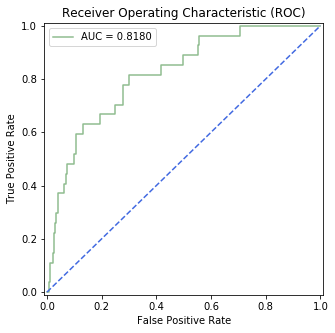

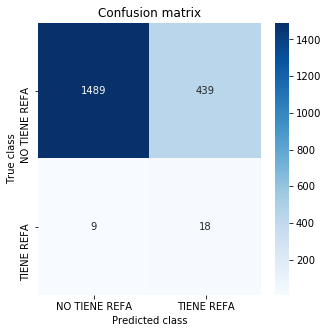

Recall: 0.6667
Precision: 0.0394
F1-score: 0.0744
G-mean: 0.7175
F-measure: 0.6673
AUCM = 0.35505


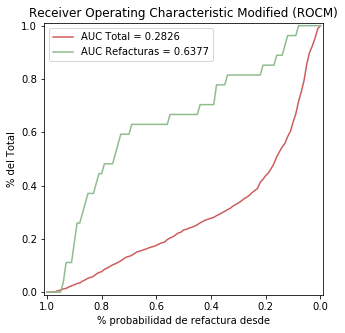

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1955 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.51% con un total de 440 registros a revisar.

Sector de facturacion 02
Codificacion lista
Dimensiones datos:  (2663, 846)
Dimensiones etiquetas:  (2663,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


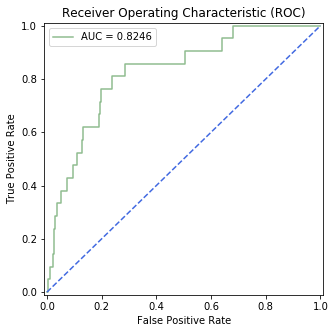

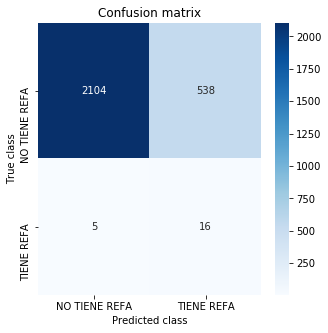

Recall: 0.7619
Precision: 0.0289
F1-score: 0.0557
G-mean: 0.7789
F-measure: 0.6828
AUCM = 0.36007


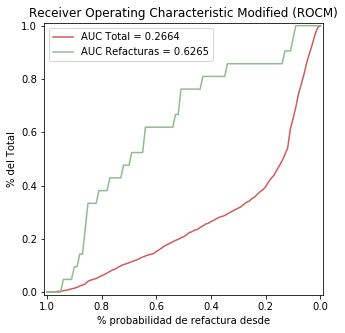

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2663 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.51% con un total de 543 registros a revisar.

Sector de facturacion 03
Codificacion lista
Dimensiones datos:  (2780, 846)
Dimensiones etiquetas:  (2780,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


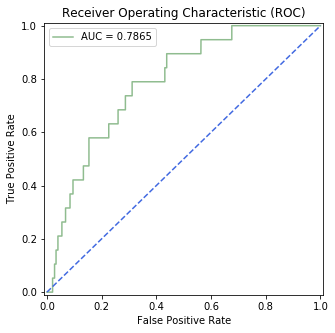

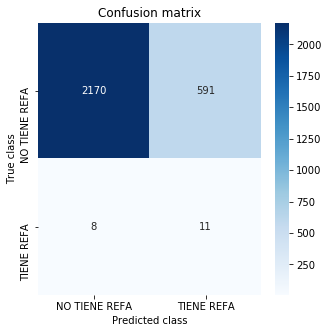

Recall: 0.5789
Precision: 0.0183
F1-score: 0.0354
G-mean: 0.6746
F-measure: 0.4901
AUCM = 0.30465


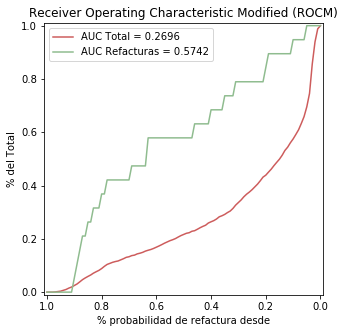

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2780 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.46% con un total de 641 registros a revisar.

Sector de facturacion 04
Codificacion lista
Dimensiones datos:  (2160, 846)
Dimensiones etiquetas:  (2160,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


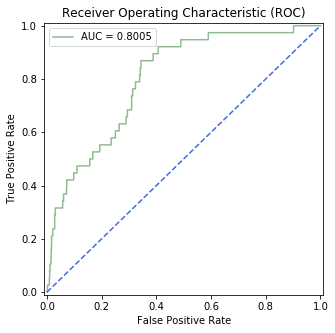

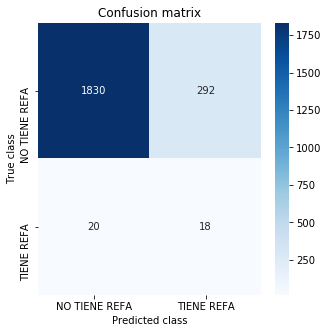

Recall: 0.4737
Precision: 0.0581
F1-score: 0.1034
G-mean: 0.6391
F-measure: 0.5317
AUCM = 0.27246


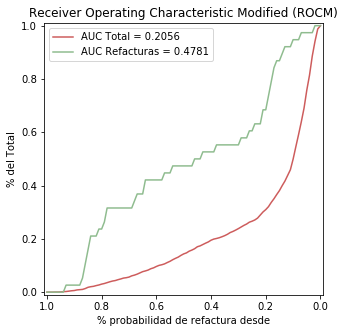

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2160 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.38% con un total de 435 registros a revisar.

Sector de facturacion 05
Codificacion lista
Dimensiones datos:  (2265, 846)
Dimensiones etiquetas:  (2265,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


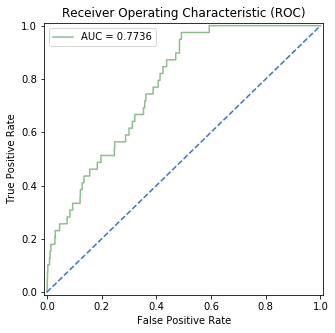

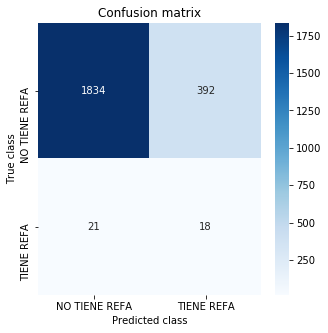

Recall: 0.4615
Precision: 0.0439
F1-score: 0.0802
G-mean: 0.6167
F-measure: 0.5017
AUCM = 0.23436


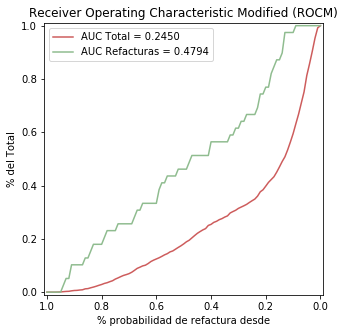

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2265 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.31% con un total de 696 registros a revisar.

Sector de facturacion 06
Codificacion lista

/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Dimensiones datos:  (2984, 846)
Dimensiones etiquetas:  (2984,)


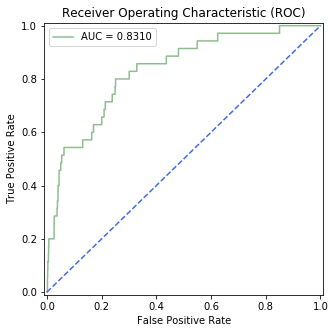

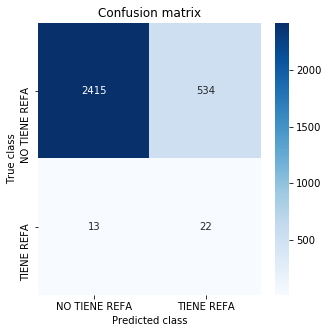

Recall: 0.6286
Precision: 0.0396
F1-score: 0.0745
G-mean: 0.7175
F-measure: 0.6373
AUCM = 0.35642


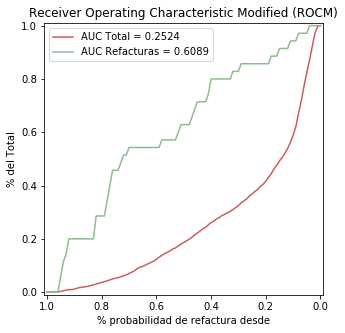

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2984 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.68% con un total de 239 registros a revisar.

Sector de facturacion 07
Codificacion lista
Dimensiones datos:  (2640, 846)
Dimensiones etiquetas:  (2640,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


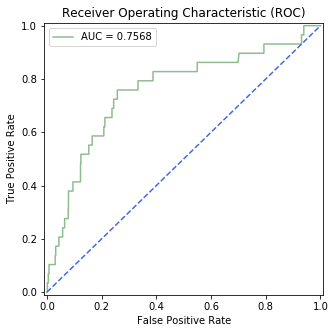

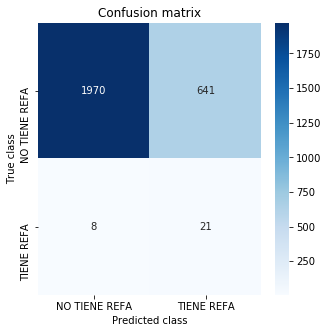

Recall: 0.7241
Precision: 0.0317
F1-score: 0.0608
G-mean: 0.7392
F-measure: 0.6755
AUCM = 0.30377


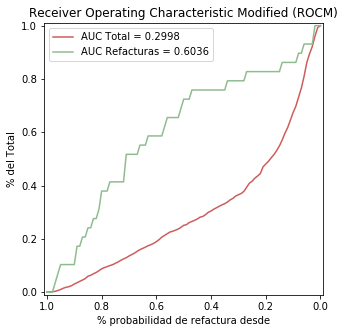

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2640 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.49% con un total de 668 registros a revisar.

Sector de facturacion 08
Codificacion lista
Dimensiones datos:  (2452, 846)
Dimensiones etiquetas:  (2452,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


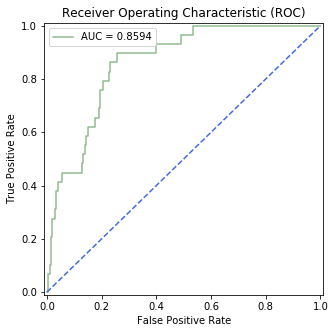

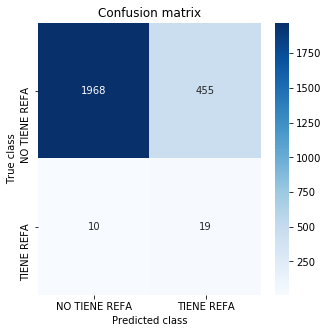

Recall: 0.6552
Precision: 0.0401
F1-score: 0.0755
G-mean: 0.7295
F-measure: 0.6605
AUCM = 0.38381


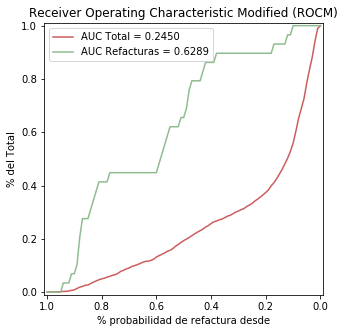

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2452 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.49% con un total de 488 registros a revisar.

Sector de facturacion 09
Codificacion lista
Dimensiones datos:  (2214, 846)
Dimensiones etiquetas:  (2214,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


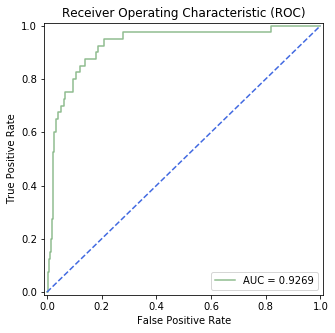

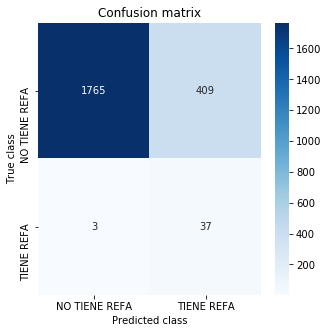

Recall: 0.9250
Precision: 0.0830
F1-score: 0.1523
G-mean: 0.8666
F-measure: 0.9970
AUCM = 0.53793


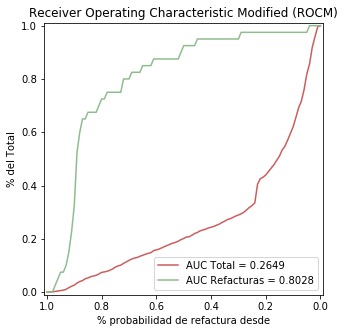

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2214 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.72% con un total de 239 registros a revisar.

Sector de facturacion 10
Codificacion lista
Dimensiones datos:  (2204, 846)
Dimensiones etiquetas:  (2204,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


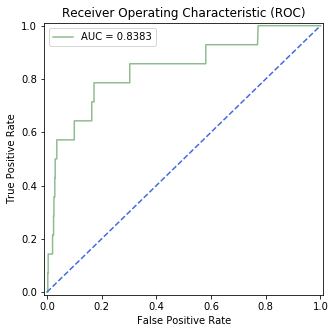

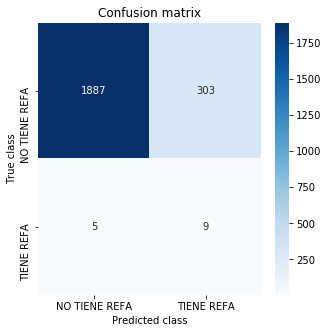

Recall: 0.6429
Precision: 0.0288
F1-score: 0.0552
G-mean: 0.7443
F-measure: 0.6035
AUCM = 0.39239


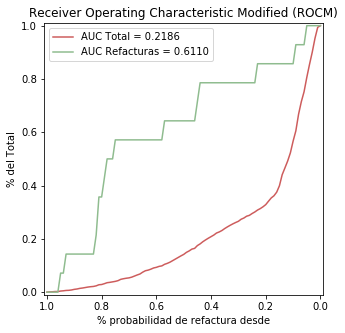

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2204 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.54% con un total de 261 registros a revisar.

Sector de facturacion 11
Codificacion lista
Dimensiones datos:  (2269, 846)
Dimensiones etiquetas:  (2269,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


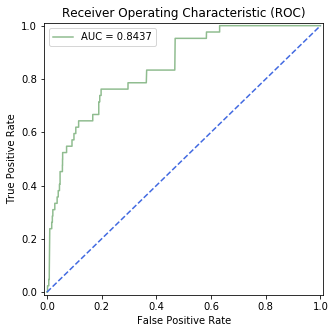

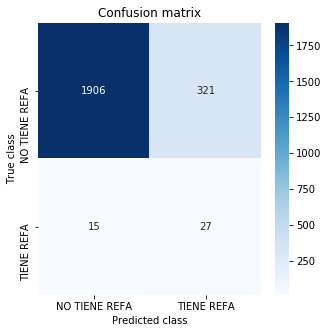

Recall: 0.6429
Precision: 0.0776
F1-score: 0.1385
G-mean: 0.7418
F-measure: 0.7204
AUCM = 0.39106


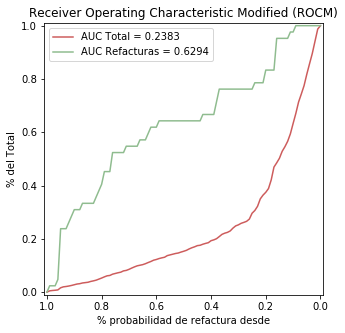

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2269 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.57% con un total de 297 registros a revisar.

Sector de facturacion 12
Codificacion lista
Dimensiones datos:  (1704, 846)
Dimensiones etiquetas:  (1704,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


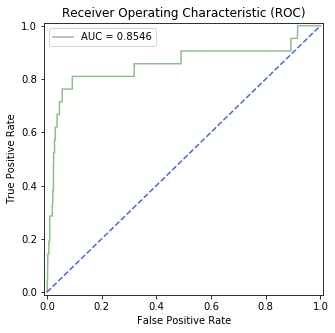

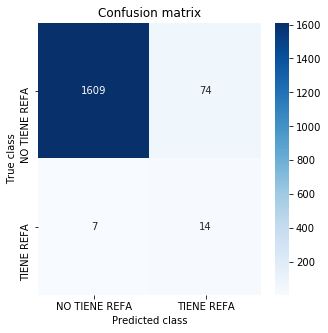

Recall: 0.6667
Precision: 0.1591
F1-score: 0.2569
G-mean: 0.7983
F-measure: 0.7919
AUCM = 0.45506


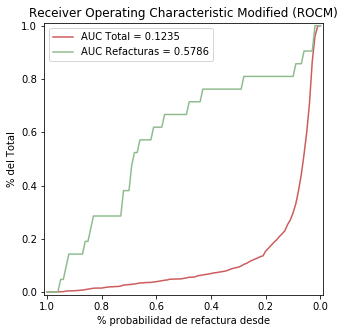

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1704 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.61% con un total de 65 registros a revisar.

Sector de facturacion 13
Codificacion lista
Dimensiones datos:  (1915, 846)
Dimensiones etiquetas:  (1915,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


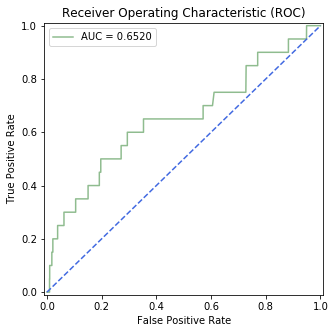

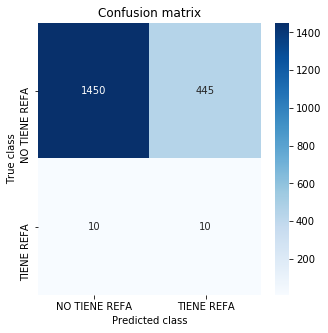

Recall: 0.5000
Precision: 0.0220
F1-score: 0.0421
G-mean: 0.6185
F-measure: 0.4669
AUCM = 0.19728


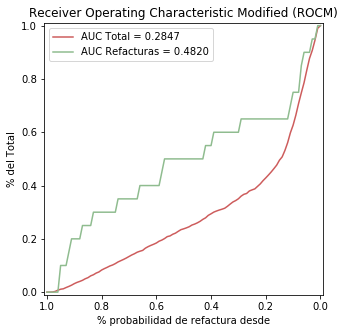

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1915 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.37% con un total de 590 registros a revisar.

Sector de facturacion 14
Codificacion lista
Dimensiones datos:  (1875, 846)
Dimensiones etiquetas:  (1875,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


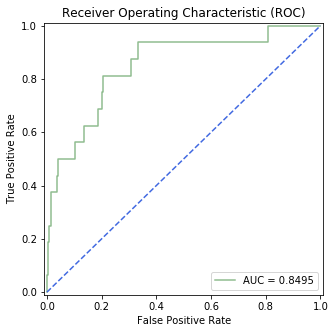

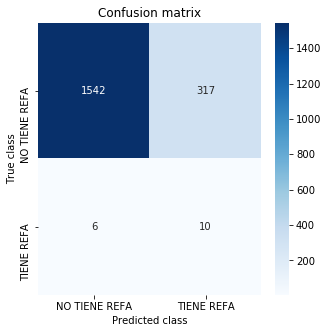

Recall: 0.6250
Precision: 0.0306
F1-score: 0.0583
G-mean: 0.7200
F-measure: 0.5996
AUCM = 0.38852


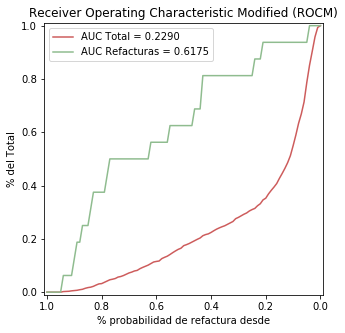

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1875 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.51% con un total de 309 registros a revisar.

Sector de facturacion 15
Codificacion lista
Dimensiones datos:  (2233, 846)
Dimensiones etiquetas:  (2233,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


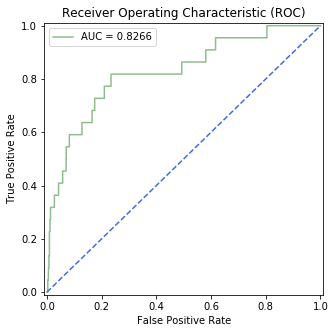

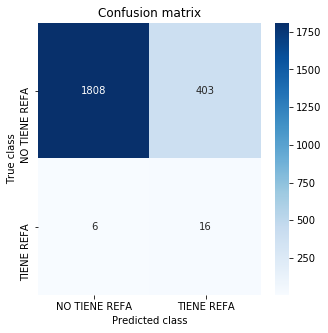

Recall: 0.7273
Precision: 0.0382
F1-score: 0.0726
G-mean: 0.7712
F-measure: 0.7094
AUCM = 0.37916


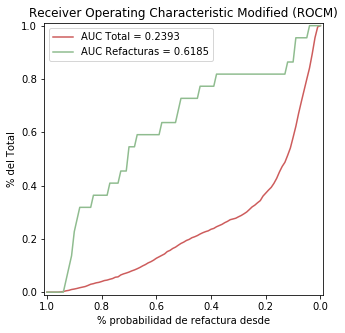

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2233 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.51% con un total de 408 registros a revisar.

Sector de facturacion 16
Codificacion lista
Dimensiones datos:  (2087, 846)
Dimensiones etiquetas:  (2087,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


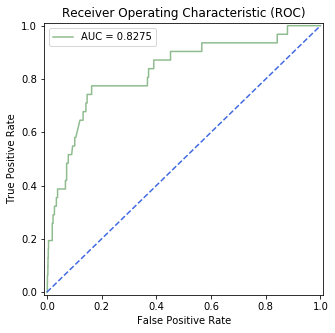

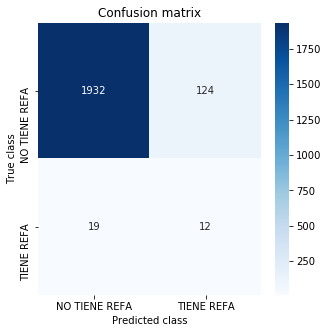

Recall: 0.3871
Precision: 0.0882
F1-score: 0.1437
G-mean: 0.6031
F-measure: 0.4585
AUCM = 0.30547


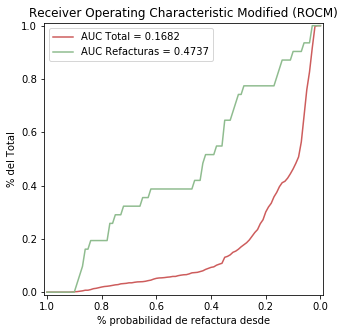

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2087 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.42% con un total de 178 registros a revisar.

Sector de facturacion 17
Codificacion lista
Dimensiones datos:  (2461, 846)
Dimensiones etiquetas:  (2461,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


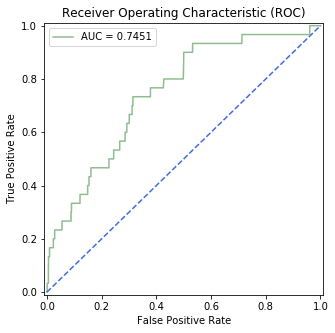

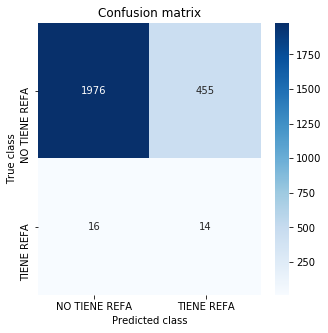

Recall: 0.4667
Precision: 0.0299
F1-score: 0.0561
G-mean: 0.6159
F-measure: 0.4747
AUCM = 0.23076


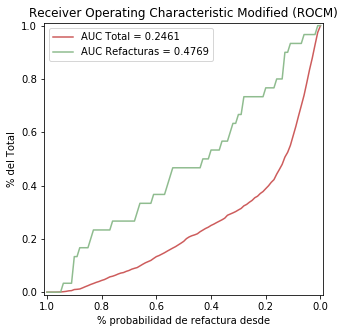

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2461 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.32% con un total de 732 registros a revisar.

Sector de facturacion 18
Codificacion lista
Dimensiones datos:  (2304, 846)
Dimensiones etiquetas:  (2304,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


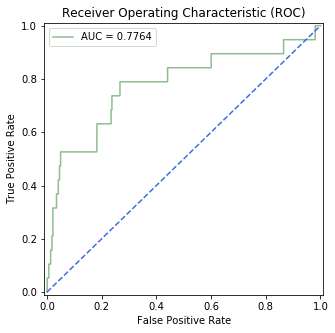

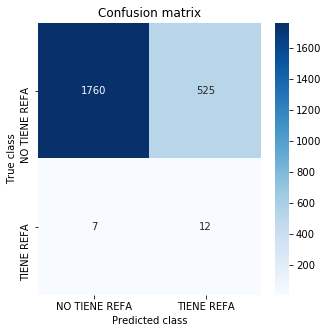

Recall: 0.6316
Precision: 0.0223
F1-score: 0.0432
G-mean: 0.6975
F-measure: 0.5545
AUCM = 0.34895


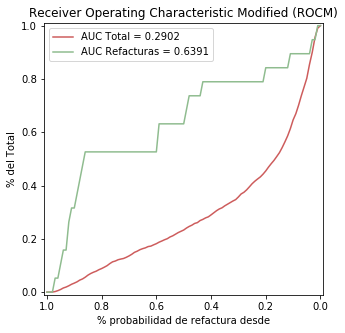

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2304 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.48% con un total de 568 registros a revisar.

Sector de facturacion 19
Codificacion lista
Dimensiones datos:  (1861, 846)
Dimensiones etiquetas:  (1861,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


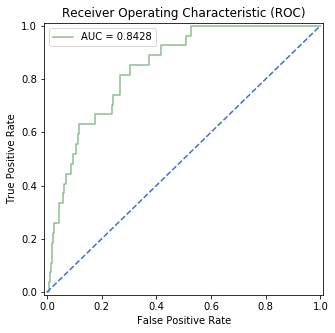

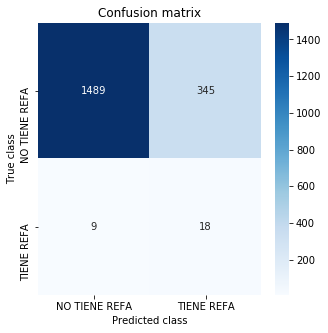

Recall: 0.6667
Precision: 0.0496
F1-score: 0.0923
G-mean: 0.7357
F-measure: 0.6973
AUCM = 0.34380


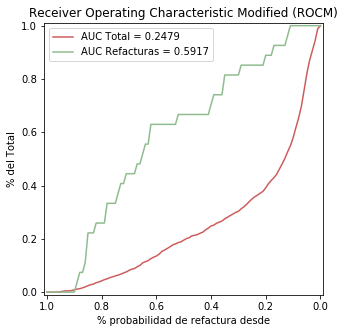

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1861 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.52% con un total de 346 registros a revisar.

Sector de facturacion 20
Codificacion lista
Dimensiones datos:  (2000, 846)
Dimensiones etiquetas:  (2000,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


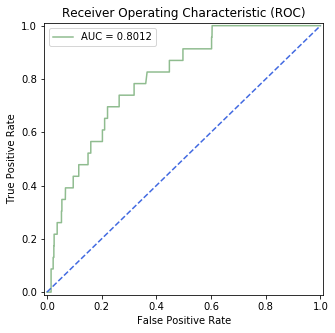

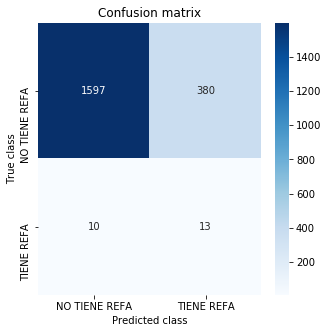

Recall: 0.5652
Precision: 0.0331
F1-score: 0.0625
G-mean: 0.6757
F-measure: 0.5646
AUCM = 0.30803


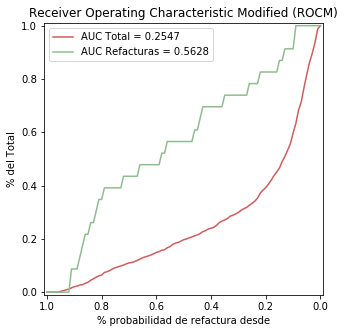

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2000 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.44% con un total de 440 registros a revisar.



In [6]:
start_time = datetime.now()
#crear variables para guardar resultados
recall = np.zeros(20)
precision = np.zeros(20)
f1_score = np.zeros(20)
g_mean = np.zeros(20)
f_beta = np.zeros(20)
AUCM = np.zeros(20)
umbral_limite = np.zeros(20)
refa_5analistas = np.zeros(20)
limite_5analistas = np.zeros(20)
maxima_diff = np.zeros(20)
maxima_diff_reg = np.zeros(20)
sector = np.zeros(20)
for i in range(0,20):
    sector[i] = i+1
#columnas para crear luego el dataframe con los resultados
columns_resultados = ['sector', 'recall', 'precision', 'f1_score', 'g_mean', 'f_beta', 'AUCM', 'umbral_limite', 'refa_5analistas',
                     'limite_5analistas', 'maxima_diff', 'maxima_diff_reg']
#paarametros de algunas metricas
umbral = 0.5
beta = 8
LABELS = ["NO TIENE REFA","TIENE REFA"]

# sectores para iterar
sectores = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

w = 0
T = 'T1'
for sec in sectores:
    print('Sector de facturacion ' + sec)
    Data_test = Data_test1.drop(Data_test1[Data_test1['RECORR1']!=sec].index)
    
    
    # predicciones
    ohe = joblib.load('../ohe.pkl')
    mini = joblib.load('../mini.pkl')
    maxi = joblib.load('../maxi.pkl')
    SS = joblib.load('../SS.pkl')
    SS_num = joblib.load('../SS_num.pkl')
    le = joblib.load('../le.pkl')
    x_test, y_test = Preprocesamiento_Datos(Data_test, splits=False,
                                            ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le)
    
    predprob_y = model_XGB.predict_proba(x_test.tocsr())
    joblib.dump(predprob_y[:,1], 'predprob_y_v3-GXB-t1.pkl') #guardo las probabilidades de prediccion

    # grafica ROC
    fpr, tpr, threshold = metrics.roc_curve(y_test, predprob_y[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    curva_ROC(fpr, tpr, roc_auc)
    
    # matriz de confusion y metricas
    predprob_y = joblib.load('predprob_y_v3-GXB-t1.pkl')
    mostrar_resultados(y_test=y_test, pred_y=predprob_y, umbral=umbral)
    recall[w], precision[w], f1_score[w], g_mean[w], f_beta[w] = MOSTRAR_METRICAS(y_test=y_test, pred_y=predprob_y,
                                                                                  umbral=umbral, beta=beta)
    
    # ROCM y datos
    umbral_limite[w], refa_5analistas[w], limite_5analistas[w], maxima_diff[w], maxima_diff_reg[w], AUCM[w] = AUCM_PLOT('predprob_y_v3-GXB-t1.pkl')
    print('Porcentaje de Refacturas revisadas en limite de analista (3500) es %0.2f' % (refa_5analistas[w]*100) + '% ' +
          'con un total de %i' % limite_5analistas[w] + ' registros a revisar con el umbral de desicion %0.2f' % (umbral_limite[w]*100))
    print('El umbral optimo de revision es %0.2f' % maxima_diff[w] + '% ' + 'con un total de %i' % maxima_diff_reg[w] + ' registros a revisar.\n')
    
    #iterador
    w = w + 1

In [7]:
# guardar resultados de cada sector en archivo csv
matriz_resultados = np.vstack((sector, recall, precision, f1_score, g_mean, f_beta, AUCM, umbral_limite, refa_5analistas,
                              limite_5analistas, maxima_diff, maxima_diff_reg))
matriz_resultados = np.transpose(matriz_resultados)

Data_resultados =  pd.DataFrame(data=matriz_resultados, columns=columns_resultados)

Data_resultados.to_csv('Data_resultados_sectores_DIC18_XGB.csv', sep=';', header=True, float_format='%.4f', encoding='utf-8')
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:01:48.284466


### Resultados NOV18

In [ ]:
# load the model from disk
#decision_tree = joblib.load('model_DT_V2.sav')